# Titanic

## Read in and assess the data

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# read in the data
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

# show the data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* PassengerId is just an identifier--this can't be used to generate predictions.
* Survived is our target.
* Pclass is the class of the passeger
* Maybe something can be extracted from Name?
* Sex is `object` type. We'll need to encode this somehow: male=`True`/`False`?
* There may be some information encoded in the ticket number. Needs further investigation after the first iteration.
* Cabin number may correspond to location in ship: deck; class; port/starboard; fore/aft. Most of the cabin numbers are unknown, so this may not be useful.
* Embarkd is encoded port of embarkment: C = Cherbourg, Q = Queenstown, S = Southampton. Needs to be encoded (one-hot)

The same transformations need to be applied to both the training and test sets, so we want to build transformation pipelines.

In [2]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are 891 passengers in the training set, 177 are missing a value for their age.
Most of the cabin numbers are unknown

These need to be dealt with in some way: impute the mean/median?

75% of passengers didn't have family on board--is this enough variance to be useful?

`Embarked` is missing two datapoints

# Exploring the relationships between variables

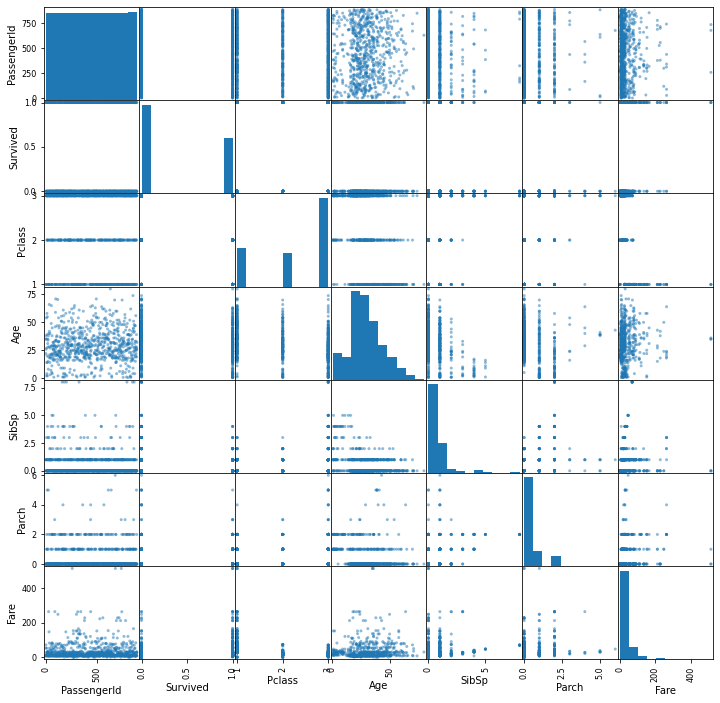

In [4]:
from pandas.plotting import scatter_matrix
scatter_matrix(train, figsize=(12,12))
plt.show()

# Data Cleansing

In [5]:
# drop the rows (n=2) with missing embarkation points (for now)
train.dropna(subset=['Embarked'], axis=0, inplace=True)

# remove the labels from the training set
X_train = train.drop('Survived', axis=1)

# create the target vector 
y_train = train['Survived'].copy()

# numerical attributes will impute missing values and be scaled
# the `Sex` features will be encoded using `OrdinalEncoder()`: 1=male, 0=Female
# the `Embarked` feature will be on-hot encoded

# load required functions
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# pipeline for numerical features
number_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# select numerical columns only
numerical_features = [c for c in X_train.select_dtypes('number').columns]

# function to apply numerical transformations and categorical encodings in one step
# unspecified columns will be dropped.
transformation_pipeline = ColumnTransformer([
    ('numerical', number_pipeline, numerical_features),
    ('sex', OrdinalEncoder(), ['Sex']),
    ('embarked', OneHotEncoder(), ['Embarked'])
], remainder='drop')

# fit the tranformations to the training set and apply
X_train_transformed = transformation_pipeline.fit_transform(X_train)

# apply the tranformations to the test set (don't fit!)
test_transformed = transformation_pipeline.transform(test)

# Benchmark with the dummy classifier
Find the accuracy (on the training set) when all passengers are predicted to die (`Survived=0`).

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_transformed, y_train)
predictions = dummy_clf.predict(X_train_transformed)
benchmark = accuracy_score(predictions, y_train)
benchmark

0.6175478065241845

So, just predicting that everyone died gives 60% accuracy. Let's beat that. 
No optimising for now, just a quick look to see what performs okay.
# Logistic regression

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

def cross_validate(model):
    """
    evaluate and print the model with 5-fold cross-validation using `accuracy` metric
    accepts: model instance (with set hyperparameters)
    returns: None
    """
    scores = cross_val_score(
        model,
        X_train_transformed,
        y_train,
        cv=5,
        scoring='accuracy'
    )
    
    print("Scores:\n",scores)
    print("Average:", np.mean(scores))
    return
    

log_clf = LogisticRegression()
cross_validate(log_clf)

Scores:
 [0.78089888 0.78651685 0.78651685 0.76966292 0.81355932]
Average: 0.7874309655303752


A simple logistic regression gives a fairly consistent accuracy of about 78% accross the folds.

## Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
cross_validate(forest_clf)

Scores:
 [0.73033708 0.78651685 0.85393258 0.82022472 0.84180791]
Average: 0.8065638291119152


Slightly higher for the random forest at 81%, but much less consistant across the folds. More trees?

## Linear SVM Classifier

In [9]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC(max_iter=10000)
cross_validate(linear_svc)

Scores:
 [0.79213483 0.78651685 0.78089888 0.75280899 0.81355932]
Average: 0.7851837745191392


Linear SVM classifier gets a consistant 79% accuracy. 
Not certain if the data is in fact linear at the moment, so maybe try a non-linear SVM classifier?
# K Nearest Neighbors Classfier

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
cross_validate(knn)

Scores:
 [0.7752809  0.78089888 0.79775281 0.80898876 0.8079096 ]
Average: 0.7941661905668761


The KNN Classifier performs about as well as the other models.
# To Do:

 * work out if the data is linear or not;
 * create more features (feature engineering)
 * remove low variace features?
 * pre-process with principle component analysis/dimensionality reduction?
 * optimise models (hyperparamter tuning) using e.g. `sklearn.model_selection.GridSearchCV()`
 * create ensemble model (hard/soft vote classifier)
 